In [1]:
import os

import pandas as pd
import scipy as sp
import scanpy as sc
sc.set_figure_params(dpi=120)

DATA_PATH = os.path.expanduser("~/scanpy_demo/")

## Load data

In [2]:
!ls $DATA_PATH

count_matrix.mtx  graph_connectivities.mtx  metadata.csv
genes.csv	  graph_distances.mtx	    pca.csv


In [3]:
gene_df = pd.read_csv(DATA_PATH + "genes.csv")

metadata = pd.read_csv(DATA_PATH + "metadata.csv")
metadata.index = metadata.CellId
del metadata["CellId"]

pca_df = pd.read_csv(DATA_PATH + "pca.csv")

graph_conn_mtx = sp.io.mmread(DATA_PATH + "graph_connectivities.mtx")
graph_dist_mtx = sp.io.mmread(DATA_PATH + "graph_distances.mtx")

### Create ScanPy object

In [4]:
adata = sc.read_mtx(DATA_PATH + "count_matrix.mtx").transpose()
adata

AnnData object with n_obs × n_vars = 12000 × 33694 

In [5]:
adata.var_names = gene_df["gene"].values
adata.obs_names = metadata.index.values

adata.obs = metadata
adata.X_pca = pca_df.values
adata.obsm["X_pca"] = adata.X_pca

adata.uns['neighbors'] = dict(connectivities=graph_conn_mtx.tocsr(), distances=graph_dist_mtx.tocsr())
adata.uns['neighbors']['params'] = dict(n_pcs=pca_df.shape[1], use_rep='X_pca', metric='cosine', method='umap', n_neighbors=30)

## Analysis

In [6]:
sc.tl.umap(adata)

... storing 'Dataset' as categorical


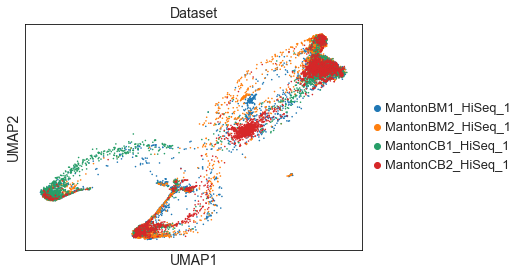

In [7]:
sc.pl.umap(adata, color="Dataset")

In [8]:
sc.tl.louvain(adata, resolution=1.5)
sc.tl.paga(adata, groups='louvain')

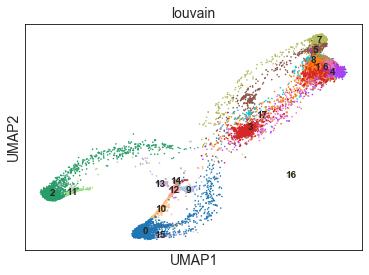

In [9]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

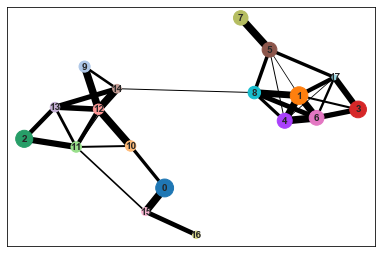

In [10]:
sc.pl.paga(adata, color='louvain', threshold=0.1, fontsize=10)